# Autoencoders

> Autoencoders


- skip_showdoc: false
- skip_exec: false

In [ ]:
#|default_exp autoencoders

In [ ]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial

from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset,load_dataset_builder

from fastprogress import progress_bar,master_bar
from fastAIcourse.datasets import *
from fastAIcourse.training import *
from fastAIcourse.convolutions import *

In [ ]:
#|export
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

## Data

In [ ]:
#| eval: false

x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

In [ ]:
#|export
@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

In [ ]:
#| eval: false
bs = 256
tds = dsd.with_transform(transformi)

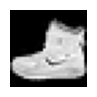

In [ ]:
#| eval: false
ds = tds['train']
img = ds[0]['image']
show_image(img, figsize=(1,1));

In [ ]:
#| eval: false
cf = collate_dict(ds)

In [ ]:
#|export
def collate_(b): return to_device(cf(b))
def data_loaders(dsd, bs, **kwargs): return {k:DataLoader(v, bs, **kwargs) for k,v in dsd.items()}

In [ ]:
#| eval: false
dls = data_loaders(tds, bs, collate_fn=collate_)

In [ ]:
#| eval: false
dt = dls['train']
dv = dls['test']

xb,yb = next(iter(dt))

In [ ]:
#| eval: false
labels = ds.features[y].names

In [ ]:
#| eval: false
labels

['T - shirt / top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
#| eval: false
lbl_getter = itemgetter(*yb[:16])
titles = lbl_getter(labels)

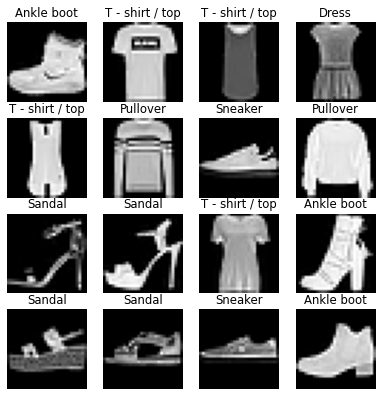

In [ ]:
#| eval: false
mpl.rcParams['figure.dpi'] = 70
show_images(xb[:16], imsize=1.7, titles=titles)

## Warmup - classify

In [ ]:
#| eval: false
from torch import optim

bs = 256
lr = 0.4

In [ ]:
#| eval: false
cnn = nn.Sequential(
    conv(1 ,4),            #14x14
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4
    conv(16,16),           #2x2
    conv(16,10, act=False),
    nn.Flatten()).to(def_device)

In [ ]:
#| eval: false
opt = optim.SGD(cnn.parameters(), lr=lr)
loss,acc = fit(5, cnn, F.cross_entropy, opt, dt, dv)

0 0.9032665767669678 0.669
1 0.5674820697307587 0.7961
2 0.4913020154953003 0.8247
3 0.4490947906255722 0.8401
4 0.42843773872852325 0.8477


In [ ]:
#| eval: false
dsd['train'][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

## Autoencoder

In [ ]:
#|export
def deconv(ni, nf, ks=3, act=True):
    layers = [nn.UpsamplingNearest2d(scale_factor=2),
              nn.Conv2d(ni, nf, stride=1, kernel_size=ks, padding=ks//2)]
    if act: layers.append(nn.ReLU())
    return nn.Sequential(*layers)

In [ ]:
#|export
def eval(model, loss_func, valid_dl, epoch=0):
    model.eval()
    with torch.no_grad():
        tot_loss,count = 0.,0
        for xb,_ in valid_dl:
            pred = model(xb)
            n = len(xb)
            count += n
            tot_loss += loss_func(pred,xb).item()*n
    print(epoch, f'{tot_loss/count:.3f}')

In [ ]:
#|export
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,_ in train_dl:
            loss = loss_func(model(xb), xb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        eval(model, loss_func, valid_dl, epoch)

In [ ]:
#| eval: false
ae = nn.Sequential(   #28x28
    nn.ZeroPad2d(2),  #32x32
    conv(1,2),        #16x16
#    conv(2,4),        #8x8
#     conv(4,8),        #4x4
#     deconv(8,4),      #8x8
#    deconv(4,2),      #16x16
    deconv(2,1, act=False), #32x32
    nn.ZeroPad2d(-2), #28x28
    nn.Sigmoid()
).to(def_device)

In [ ]:
#| eval: false
eval(ae, F.mse_loss, dv)

0 0.151


In [ ]:
#| eval: false
opt = optim.SGD(ae.parameters(), lr=0.01)
fit(5, ae, F.mse_loss, opt, dt, dv)

0 0.136
1 0.115
2 0.087
3 0.071
4 0.060


In [ ]:
#| eval: false
opt = optim.SGD(ae.parameters(), lr=0.1)
fit(5, ae, F.mse_loss, opt, dt, dv)

0 0.026
1 0.020
2 0.017
3 0.016
4 0.014


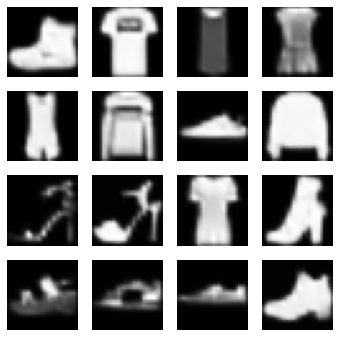

In [ ]:
#| eval: false
p = ae(xb)
show_images(p[:16].data.cpu(), imsize=1.5)

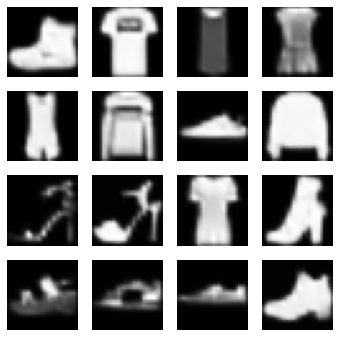

In [ ]:
#| eval: false
p = ae(xb)
show_images(p[:16].data.cpu(), imsize=1.5)

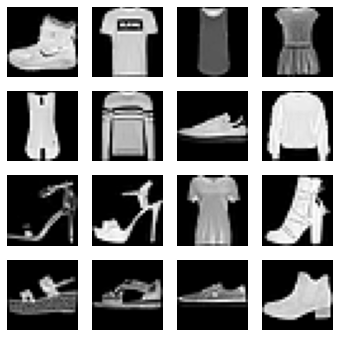

In [ ]:
#| eval: false
show_images(xb[:16].data.cpu(), imsize=1.5)